# Sentiment Analysis Pipeline for Reviews

1. Normalize Reviews
2. Preprocess Reviews for Sentiment Analysis
3. Sentiment Analysis
4. Exploratory Data Analysis

## 1. Normalize Reviews
1.	Removing duplicated rows
2.	Normalize date to year
3.	Normalize ratings to 10

In [1]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

def normalize_reviews(filepath):
  '''
  1. Drop duplicated rows
  2. Normalize dates to only the year
  3. Normalize ratings to 10
  '''
  
  df = pd.read_excel(filepath)
  
  # Drop duplicated rows
  df.drop_duplicates(keep='first', inplace=True)
  
  '''
  1. Normalize dates to only year
    - fix_date_week | fix_date_month | fix_date_year
      - Takes current date and minus off respective week, month or year
  '''
  
  def fix_date_week(week):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(weeks=week)
    return newdate
  
  def fix_date_month(month):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(months=month)
    return newdate
  
  def fix_date_year(year):
    date = datetime.datetime.now()
    date = date.date()
    newdate = date - relativedelta(years=year)
    return newdate
  
  # Replace date strings with proper year
  # Only up to 10 years
  replace_date = {'seminggu lalu': fix_date_week(1),
                  '2 minggu lalu': fix_date_week(2),
                  '3 minggu lalu': fix_date_week(3),
                  'sebulan lalu': fix_date_month(1),
                  '2 bulan lalu': fix_date_month(2),
                  '3 bulan lalu': fix_date_month(3),
                  '4 bulan lalu': fix_date_month(4),
                  '5 bulan lalu': fix_date_month(5),
                  '6 bulan lalu': fix_date_month(6),
                  '7 bulan lalu': fix_date_month(7),
                  '8 bulan lalu': fix_date_month(8),
                  '9 bulan lalu': fix_date_month(9),
                  '10 bulan lalu': fix_date_month(10),
                  '11 bulan lalu': fix_date_month(11),
                  'setahun lalu': fix_date_year(1),
                  '2 tahun lalu': fix_date_year(2),
                  '3 tahun lalu': fix_date_year(3),
                  '4 tahun lalu': fix_date_year(4),
                  '5 tahun lalu': fix_date_year(5),
                  '6 tahun lalu': fix_date_year(6),
                  '7 tahun lalu': fix_date_year(7),
                  '8 tahun lalu': fix_date_year(8),
                  '9 tahun lalu': fix_date_year(9),
                  '10 tahun lalu': fix_date_year(10),}
  
  # Split dataframe with proper datetime format
  df1 = df[df['date'].apply(lambda x: isinstance(x, datetime.date))]
  # Split dataframe with date strings
  df2 = df[df['date'].apply(lambda x: not isinstance(x, datetime.date))]
  # Replace date strings with proper year
  df2 = df2.replace({"date": replace_date})
  
  # Only extract year
  df1['date'] = pd.DatetimeIndex(df1['date']).year
  df2['date'] = pd.DatetimeIndex(df2['date']).year
  
  # Concatenate fixed year
  df = pd.concat([df1, df2], ignore_index=True)
  
  #2. Normalize ratings to 10
  
  # Replace Klook ratings with 'Baik' to 8 and 'Sangat Direkomendasikan' to 10
  replace_rating = {'Baik': 8,
                  'Sangat Direkomendasikan': 10}
  df = df.replace({'rating': replace_rating})
  
  # Mask for TripAdvisor ratings
  mask = (df['source'] == 'tripadvisor')
  # Retrieve index 0 string of rating and multiply by 2
  df.loc[mask, 'rating'] = (df.loc[mask, 'rating'].str[0].astype(int))*2
  
  # Mask for Google Review ratings
  mask2 = (df['source'] == 'google_reviews')
  # Retrieve index 14 string of rating and multiply by 2
  df.loc[mask2, 'rating'] = (df.loc[mask2, 'rating'].str[14].astype(int))*2
  
  return df

In [2]:
# Enter input filepath
df = normalize_reviews("../preprocess_review/raw_data/uss_master_copy.xlsx")
df.head()

C:\Users\Luqman\AppData\Local\Temp\ipykernel_6348\580919387.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.DatetimeIndex(df1['date']).year


,user,date,rating,review,page_url,date_scraped,source,attraction
0,mpocasino,2020,10,Universal Studio Singapore yang berada di Pula...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
1,Rudy K,2019,10,cukup beruntung hanya membeli tiket biasa dapa...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
2,Alma Jaya,2019,10,Tempat liburan keluarga yang sangat menarik un...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
3,Sri Pratiwi,2020,10,Beli tiketnya via OTA dan kebetulan sudah prin...,https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss
4,Didik K,2020,10,"Jalan jalan bareng si kecil, emang menyenangka...",https://www.tripadvisor.co.id/Attraction_Revie...,4/26/2022,tripadvisor,uss


In [3]:
# For export use later
attraction = df['attraction'][0]

## 2. Preprocessing for Sentiment Analysis

  - Lowercasing reviews
  - Demoji and translate to Bahasa Indonesia
  - Remove punctuation and symbols
  - Fix slang words
  - Summarize reviews with more than 1536 characters
  - Stemming
  - Remove stop words

In [4]:
# Drop irrelevant columns
df.drop(['user','page_url','date_scraped','attraction'], axis=1, inplace=True)
df.head()

,date,rating,review,source
0,2020,10,Universal Studio Singapore yang berada di Pula...,tripadvisor
1,2019,10,cukup beruntung hanya membeli tiket biasa dapa...,tripadvisor
2,2019,10,Tempat liburan keluarga yang sangat menarik un...,tripadvisor
3,2020,10,Beli tiketnya via OTA dan kebetulan sudah prin...,tripadvisor
4,2020,10,"Jalan jalan bareng si kecil, emang menyenangka...",tripadvisor


In [5]:
# Imports
import numpy as np
import pandas as pd
import ast
import re

import spacy
id_nlp = spacy.blank('id')

from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
import translators as ts
ts._google.language_map

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from transformers import pipeline

Using Singapore server backend.


In [6]:
# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Create summary model
summary_model = pipeline("summarization",
                model="cahya/t5-base-indonesian-summarization-cased",
                tokenizer="cahya/t5-base-indonesian-summarization-cased")

# Stop words
nlp = spacy.load("en_core_web_lg")
eng_stopwords = set(line.strip() for line in open('../resources/stop_words_english.txt', encoding='utf-8'))
id_stopwords = set(line.strip() for line in open('../resources/stop_words_bahasaindonesia.txt', encoding='utf-8'))
new_stopwords = eng_stopwords.union(id_stopwords)

# Add new set of stopwords into spacy stopword list
nlp.Defaults.stop_words |= new_stopwords

In [7]:
def preprocess_sentiment(df):
  '''
  Preprocessing
  - Lowercasing reviews
  - Translate emojis/emoticons to Bahasa Indonesia
  - Remove punctuation and symbols
  - Remove empty rows
  - Fix slang words
  - Summarize reviews with more than 1536 characters
  - Stemming
  - Remove stop words
  '''
  file = open("../resources/bahasa_indonesia_slangwords.txt", "r")
  contents = file.read()
  slangwords = ast.literal_eval(contents)
  
  def tokenize_id(text):
    text_list = [token.text for i, token in enumerate(id_nlp(text))]
    return text_list
  
  def translate_emoji(text):
    '''
    Tokenizes review using SpaCy Indonesia, replace any emoji with English form and translate it to Indonesian
    '''
    all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
    all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}
    
    text_list = tokenize_id(text.replace("  ", ""))
    for index, token in enumerate(text_list):
        for key, value in all_emoji_emoticons.items():
            if key in token:
                text_list[index]=token.replace(key, ts.google(all_emoji_emoticons[key], from_language='en', to_language='id'))
                
    rejoin_text = ' '.join(text_list)
    return rejoin_text
  
  df['new_reviews'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
  df['new_reviews'] = df['new_reviews'].apply(lambda x: translate_emoji(x))
  df['new_reviews'] = df['new_reviews'].str.replace('[^\w\s]','',regex=True)
  
  # Remove empty rows
  df[df['new_reviews'].str.strip().astype(bool)]
  
  # Fix slang words
  df['new_reviews'] = df['new_reviews'].apply(lambda x: " ".join(slangwords.get(word, word) for word in tokenize_id(x)))
  
  # Summarize reviews
  # Reviews more than 1536 characters (Average indonesian word has 3 characters times 512 which is max sentiment tensor input)
  mask = (df['new_reviews'].str.len() >= 1536)
  df.loc[mask, 'new_reviews'] = df.loc[mask, 'new_reviews'].apply(lambda x: summary_model(x)[0]['summary_text']).str.replace('[^\w\s]','',regex=True)
  
  # Stemming
  df['new_reviews'] = df['new_reviews'].apply(lambda x: stemmer.stem(x))
  
  # Remove stop words
  df['new_reviews'] = df['new_reviews'].apply(lambda text: 
                                          " ".join(token.text for token in nlp(text) 
                                                   if not token.is_stop))
  
  # Remove empty rows in case review only contain stop words
  df['new_reviews'].replace('', np.nan, inplace=True)
  df.dropna(subset=['new_reviews'], inplace=True)

In [8]:
preprocess_sentiment(df)

In [9]:
# Rearrange dataframe
df = df[['date', 'source', 'review', 'new_reviews', 'rating']]
df.head()

,date,source,review,new_reviews,rating
0,2020,tripadvisor,Universal Studio Singapore yang berada di Pula...,universal studio singapore pulau sentosa singa...,10
1,2019,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...,untung beli tiket hampir aktrasi pagipagi cuac...,10
2,2019,tripadvisor,Tempat liburan keluarga yang sangat menarik un...,libur keluarga tarik kunjung sarana rekreasi e...,10
3,2020,tripadvisor,Beli tiketnya via OTA dan kebetulan sudah prin...,beli tiket ota print rumah uss tugas barcodeny...,10
4,2020,tripadvisor,"Jalan jalan bareng si kecil, emang menyenangka...",jalan jalan bareng si kecil senang bagus senan...,10


## Sentiment Analysis

### Validate Models

In [ ]:
# Only ran this cell once to retrieve random 50 rows for validation

'''
dfn = pd.read_excel("../preprocess_review/output/normalize_data/uss_reviews_normalized.xlsx")
dfn.drop(['date', 'rating', 'user','page_url','date_scraped','attraction', 'source'], axis=1, inplace=True)
df_valid = dfn.sample(50, replace=False) 
df_valid.to_excel("validate.xlsx", index=False)
'''

In [4]:
# Load in data after labelling sentiment
# df_labelled = pd.read_excel("validate_labelled.xlsx")
# df_labelled.head()

,review,self_sentiment
0,Tempat yang tak cukup dikelilingi 1 hari..Good...,positive
1,Biasa saja dan tidak ada yg baru,neutral
2,"Bagus banget , rugi kalau ga kesini kalau udah...",positive
3,Salah satu destinasi wisata populer di Singapu...,neutral
4,Tapi saya foto depan bola nya doang. Gak masuk...,negative


In [5]:
# Preprocess df
# preprocess_sentiment(df_labelled)

In [6]:
# Rearrange dataframe
# df_labelled = df_labelled[['review', 'new_reviews', 'self_sentiment']]
# df_labelled.head()

,review,new_reviews,self_sentiment
0,Tempat yang tak cukup dikelilingi 1 hari..Good...,keliling 1 good place hati,positive
2,"Bagus banget , rugi kalau ga kesini kalau udah...",bagus banget rugi kesini singapore,positive
3,Salah satu destinasi wisata populer di Singapu...,ngomongngomong mahal ye temanteman 15an,neutral
4,Tapi saya foto depan bola nya doang. Gak masuk...,foto bola doang masuk uang sedi aink cemberut ...,negative
5,Waaah seru banget sih masuk USS gak nyesel. Ak...,waaah seru banget sih masuk uss nyesel kesini ...,positive


In [7]:
# from transformers import pipeline
# import sentencepiece

# def get_sentiment(text, modelname):
#     sentiment_model = pipeline(
#                                 'sentiment-analysis',
#                                 model=modelname,
#                                 tokenizer=modelname
#                               )
#     prediction = sentiment_model(text)[0]['label']
#     return prediction.lower()

In [ ]:
# models = ["sahri/indonesiasentiment", 
#           "w11wo/indonesian-roberta-base-sentiment-classifier", 
#           "ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa", 
#           "tyqiangz/indobert-lite-large-p2-smsa", 
#           ]

In [9]:
# df_labelled["sahri"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment(x, models[0]))
# df_labelled["w11wo"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment(x, models[1]))
# df_labelled["ayameRushia"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment(x, models[2]))
# df_labelled["tyqiangz"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment(x, models[3]))

In [10]:
# Google Cloud Platform

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="sdcsentiment-584f24f06d91.json"

# Imports the Google Cloud client library
from google.cloud import language_v1

# Instantiates a client
client = language_v1.LanguageServiceClient()

In [11]:
def get_sentiment_gcp(text):
  document = language_v1.Document(
    content=text, type_=language_v1.Document.Type.PLAIN_TEXT, language='id'
)
  sentiment = client.analyze_sentiment(
    request={"document": document}
).document_sentiment
  
  if sentiment.score >= 0.5:
    output = 'positive'
  elif sentiment.score >= 0:
    output = 'neutral'
  else:
    output = 'negative'
  return output

In [24]:
# df_labelled["gcp"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment_gcp(x))

In [27]:
# df_labelled.head()

,review,new_reviews,self_sentiment,sahri,w11wo,ayameRushia,tyqiangz,gcp
0,Tempat yang tak cukup dikelilingi 1 hari..Good...,keliling 1 good place hati,positive,positive,positive,neutral,positive,positive
2,"Bagus banget , rugi kalau ga kesini kalau udah...",bagus banget rugi kesini singapore,positive,positive,positive,negative,negative,positive
3,Salah satu destinasi wisata populer di Singapu...,ngomongngomong mahal ye temanteman 15an,neutral,negative,negative,negative,negative,neutral
4,Tapi saya foto depan bola nya doang. Gak masuk...,foto bola doang masuk uang sedi aink cemberut ...,negative,negative,negative,negative,negative,negative
5,Waaah seru banget sih masuk USS gak nyesel. Ak...,waaah seru banget sih masuk uss nyesel kesini ...,positive,positive,positive,positive,positive,positive


In [28]:
# Comparison between sentiment models

# sahri_acc = round(len(df_labelled.loc[df_labelled.self_sentiment == df_labelled.sahri]) / 49 *100, 2)
# w11wo_acc = round(len(df_labelled.loc[df_labelled.self_sentiment == df_labelled.w11wo]) / 49 *100, 2)
# ayame_acc = round(len(df_labelled.loc[df_labelled.self_sentiment == df_labelled.ayameRushia]) / 49 *100, 2)
# tyqiangz_acc = round(len(df_labelled.loc[df_labelled.self_sentiment == df_labelled.tyqiangz]) / 49 *100, 2)
# gcp_acc = round(len(df_labelled.loc[df_labelled.self_sentiment == df_labelled.gcp]) / 49 *100, 2)

# print(f"sahri/indonesiasentiment Accuracy: {sahri_acc}%")
# print(f"w11wo/indonesian-roberta-base-sentiment-classifier Accuracy: {w11wo_acc}%")
# print(f"ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa Accuracy: {ayame_acc}%")
# print(f"tyqiangz/indobert-lite-large-p2-smsa Accuracy: {tyqiangz_acc}%")
# print(f"GCP Accuracy: {gcp_acc}%")

sahri/indonesiasentiment Accuracy: 67.35%
w11wo/indonesian-roberta-base-sentiment-classifier Accuracy: 67.35%
ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa Accuracy: 55.1%
tyqiangz/indobert-lite-large-p2-smsa Accuracy: 63.27%
GCP Accuracy: 75.51%


### Sentiment Analysis using Google Cloud Platform

In [12]:
df['sentiment'] = df['new_reviews'].apply(lambda x: get_sentiment_gcp(x))

In [13]:
df = df[['date', 'source', 'review', 'new_reviews', 'rating', 'sentiment']]
df

,date,source,review,new_reviews,rating,sentiment
0,2020,tripadvisor,Universal Studio Singapore yang berada di Pula...,universal studio singapore pulau sentosa singa...,10,neutral
1,2019,tripadvisor,cukup beruntung hanya membeli tiket biasa dapa...,untung beli tiket hampir aktrasi pagipagi cuac...,10,positive
2,2019,tripadvisor,Tempat liburan keluarga yang sangat menarik un...,libur keluarga tarik kunjung sarana rekreasi e...,10,positive
3,2020,tripadvisor,Beli tiketnya via OTA dan kebetulan sudah prin...,beli tiket ota print rumah uss tugas barcodeny...,10,positive
4,2020,tripadvisor,"Jalan jalan bareng si kecil, emang menyenangka...",jalan jalan bareng si kecil senang bagus senan...,10,positive
...,...,...,...,...,...,...
3123,2020,google_reviews,Sukses selalu Singapura,sukses singapura,10,positive
3124,2020,google_reviews,Tempat e asyik,e asyik,10,positive
3125,2016,google_reviews,Keren bgt...♥Q sdh pernh dtng ke sana,keren banget hati q sdh pernh dtng,8,positive
3126,2019,google_reviews,Bagus,bagus,10,positive


In [14]:
# Add Length and Word Count 
df['review_len'] = df['new_reviews'].astype(str).apply(len)
df['word_count'] = df['new_reviews'].apply(lambda x: len(str(x).split()))

In [15]:
# Export data
df.to_excel(f'{attraction}_sentiment.xlsx', index=False)
df.to_csv(f'{attraction}_sentiment.csv', index=False)

## Analysis & Visualization

- Review Rating Distribution
- Review Length Distribution
- Review Word Count Distribution
- Ratings vs. Sentiment
- Sentiment Share Overall
- Word Cloud
- Top Word Frequency
- Top 15 Words For Positive Sentiment
- Top 15 Words For Neutral Sentiment
- Top 15 Words For Negative Sentiment

**TODO**
- Review length based on ratings
- Review length based on sentiment
- Distribution plots on website

In [16]:
df.groupby(['rating'])['new_reviews'].count()

rating
2        3
4       11
5       14
6      112
8      781
9      331
10    1868
Name: new_reviews, dtype: int64

### The distribution of ratings

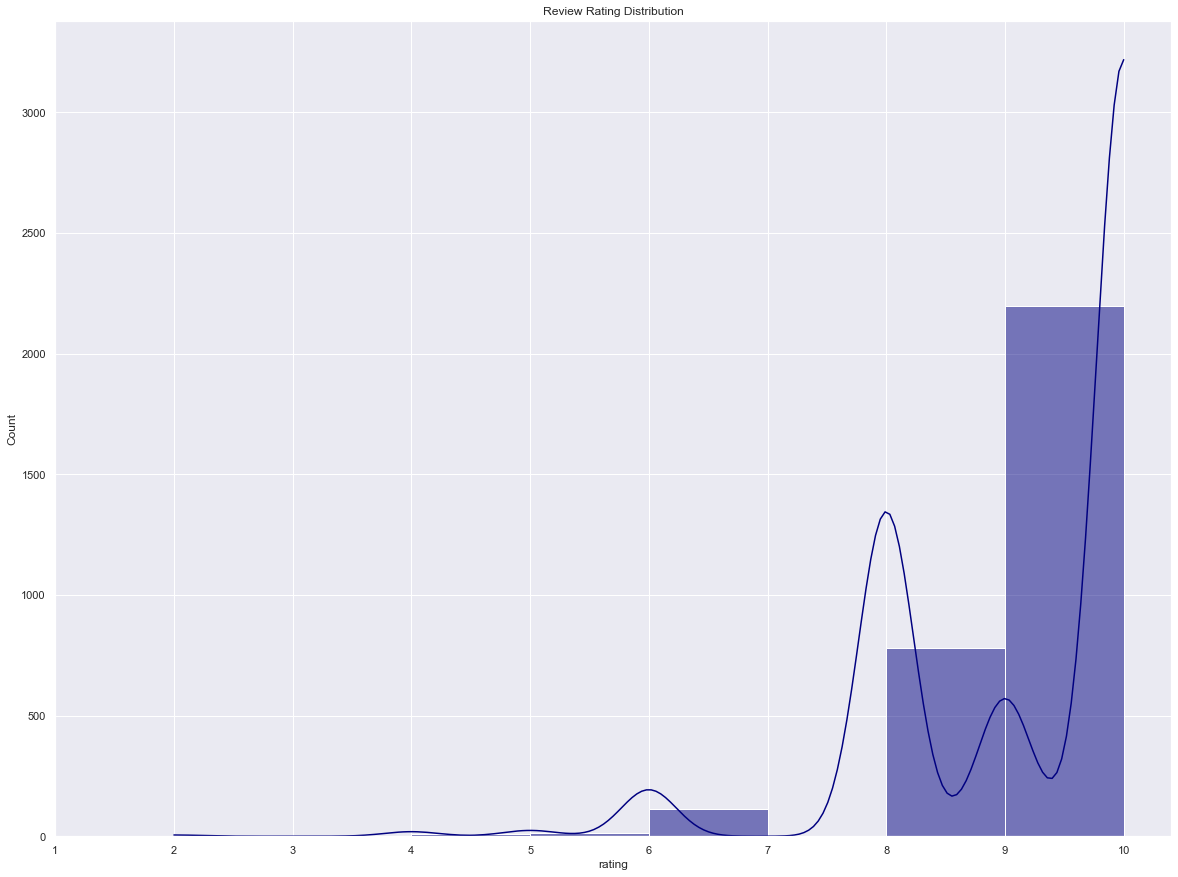

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ratings_dist = sns.histplot(
    data=df,
    x="rating",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.xticks(range(1,11))
plt.title("Review Rating Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### The distribution of review text lengths

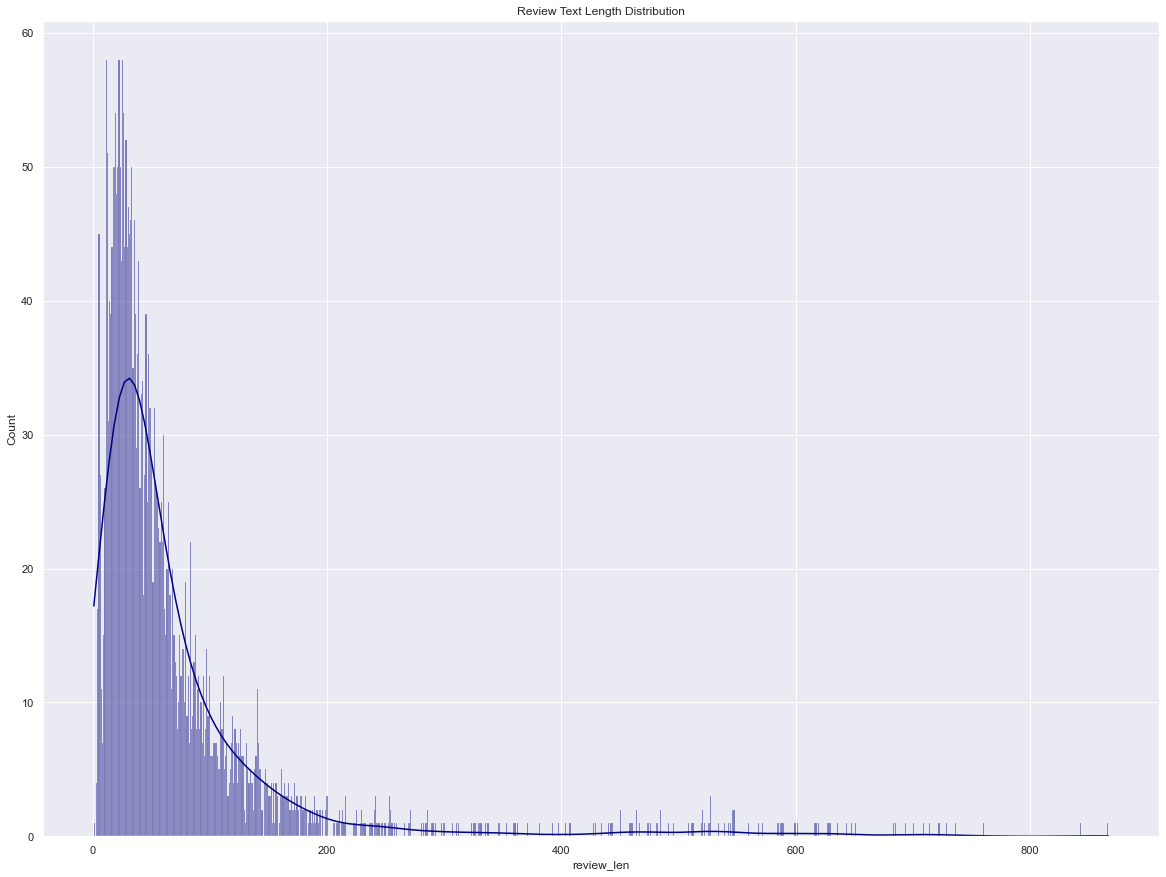

In [20]:
review_length_dist = sns.histplot(
    data=df,
    x="review_len",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.title("Review Text Length Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### The distribution of review word count

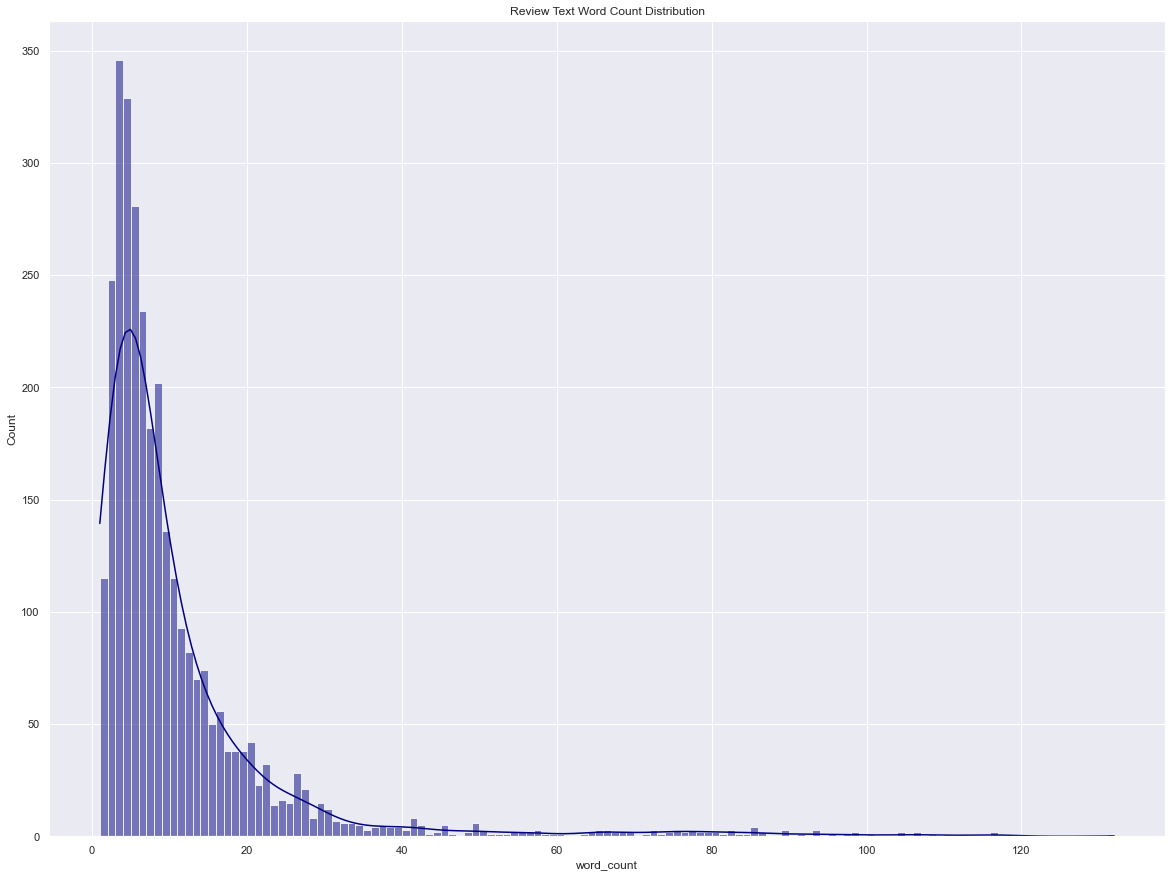

In [21]:
review_length_dist = sns.histplot(
    data=df,
    x="word_count",
    color='navy',
    bins=10,
    binwidth=1,
    kde=True
)

plt.title("Review Text Word Count Distribution")
sns.set_theme(rc={'figure.figsize':(20,15)},
              style="darkgrid")

### Ratings vs. Sentiment

In [22]:
df.groupby(['rating','sentiment'])['new_reviews'].count()

rating  sentiment
2       neutral         1
        positive        2
4       negative        4
        neutral         2
        positive        5
5       negative        3
        neutral         8
        positive        3
6       negative       13
        neutral        38
        positive       61
8       negative       27
        neutral       126
        positive      628
9       negative        5
        neutral        41
        positive      285
10      negative       55
        neutral       243
        positive     1570
Name: new_reviews, dtype: int64

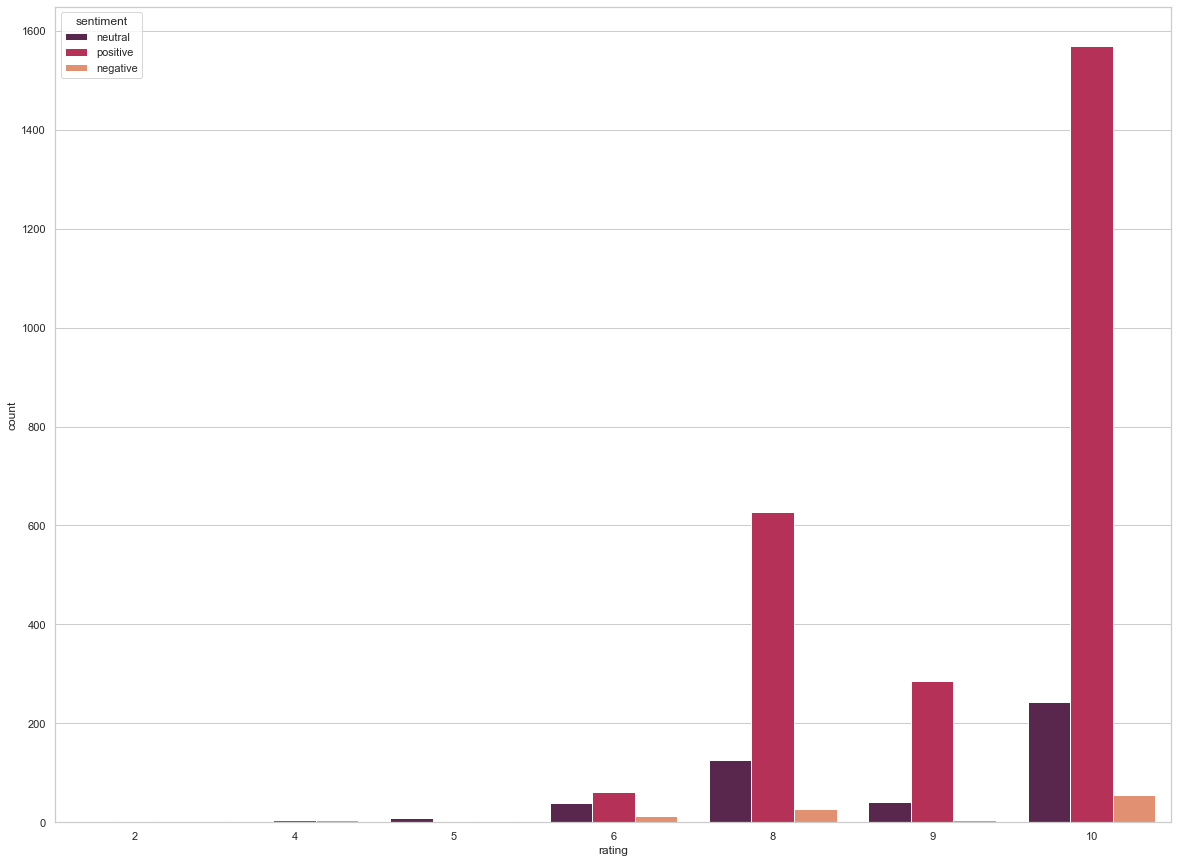

In [23]:
sns.set_theme(style="whitegrid")

rating_vs_sentiment = sns.countplot(
    data=df,
    x="rating", hue="sentiment", palette="rocket",
)
sns.set_theme(rc={'figure.figsize':(20,15)})

### Sentiment Share for USS Attraction

<AxesSubplot:ylabel='new_reviews'>

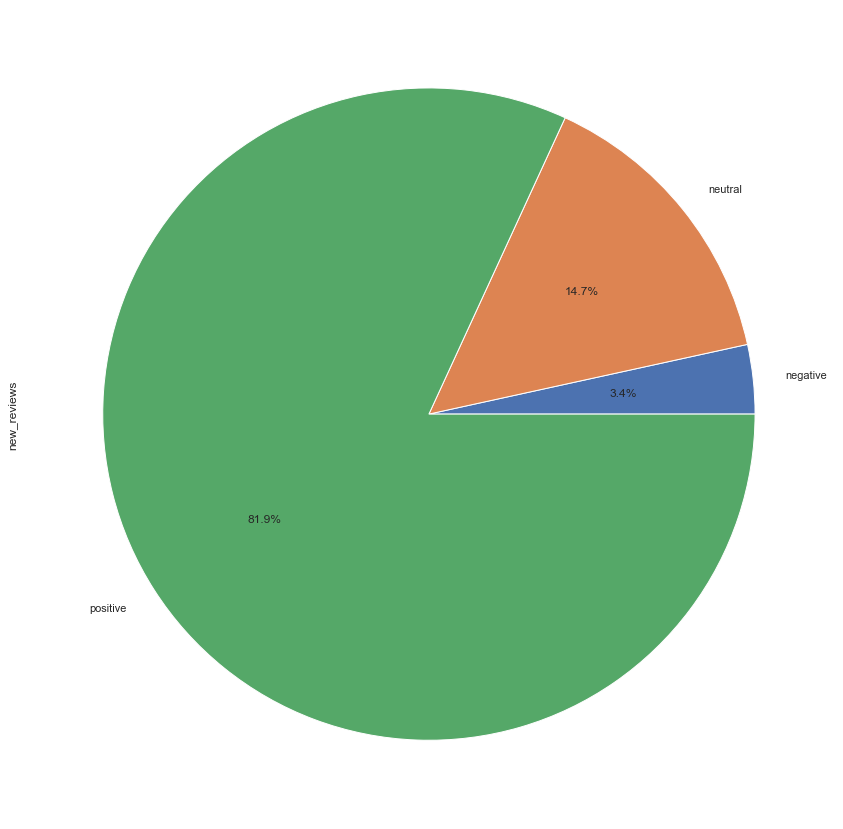

In [24]:
sentiment_share_overall = df.groupby('sentiment')['new_reviews'].count()
sentiment_share_overall.plot.pie(autopct="%.1f%%")

### Word Cloud

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img_mask = np.array(Image.open('singaporemask.jpg'))

def show_wordcloud(data, output = None):
    '''
    Generate word cloud with color function
    output = Figure output name
    '''
    def one_color_func(word=None, font_size=None, position=None, 
                   orientation=None, font_path=None, random_state=None):
        h = 36 # 0 - 360
        s = 100 # 0 - 100
        l = 50
        # l = random_state.randint(30, 70) # 0 - 100
        return "hsl({}, {}%, {}%)".format(h, s, l)

    wordcloud = WordCloud(
        width=img_mask.shape[1], 
        height=img_mask.shape[0],
        colormap='Pastel1',
        mask=img_mask,
        color_func=one_color_func,
        background_color='white',
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.savefig(f'figures/{attraction}_{output}_wordcloud.png', bbox_inches='tight')
    plt.show()

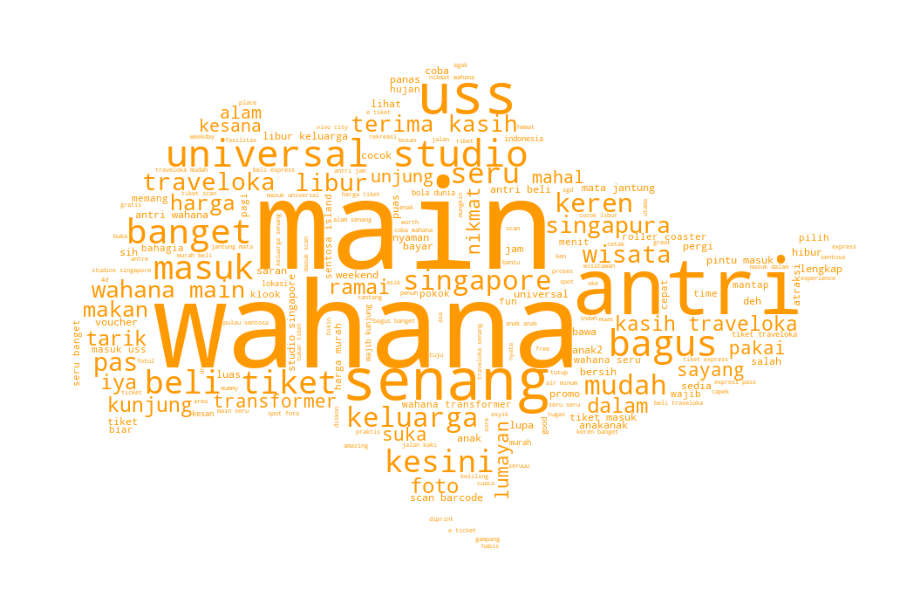

In [26]:
text = " ".join(i for i in df.new_reviews)
show_wordcloud(text, "overall")

### Top 15 Words Overall

In [27]:
top_words = WordCloud().process_text(text)
top_words = pd.DataFrame(top_words.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
top_words.to_excel(f"{attraction}_topwords.xlsx", sheet_name='overall', index=False)
top_words.head(15)

,word,frequency
6,main,592
5,wahana,542
77,antri,475
45,senang,432
29,uss,404
3398,universal studio,337
46,bagus,328
66,banget,290
33,masuk,270
3404,beli tiket,236


### Top Words in Positive Sentiment

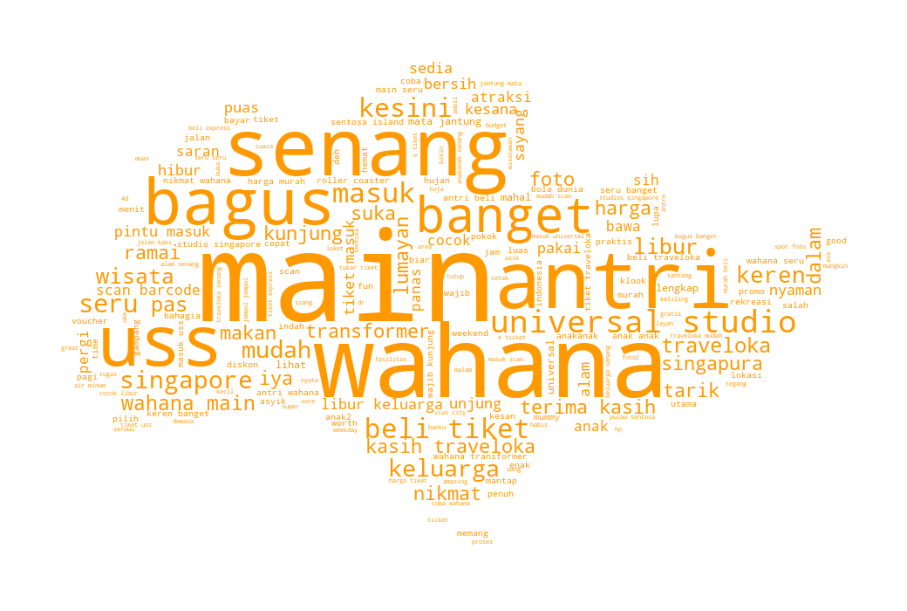

In [29]:
mask = (df['sentiment'] == 'positive')
pos_df = df[mask]
pos_text = " ".join(i for i in pos_df.new_reviews)
show_wordcloud(pos_text, "positive")

In [30]:
# For new sheet on same excel file
import os

def save_excel_sheet(df, filepath, sheetname, index=False):
    # Create file if it does not exist
    if not os.path.exists(filepath):
        df.to_excel(filepath, sheet_name=sheetname, index=index)

    # Otherwise, add a sheet. Overwrite if there exists one with the same name.
    else:
        with pd.ExcelWriter(filepath, engine='openpyxl', if_sheet_exists='replace', mode='a') as writer:
            df.to_excel(writer, sheet_name=sheetname, index=index)

In [31]:
pos_wordcount = WordCloud().process_text(pos_text)
pos_wordcount = pd.DataFrame(pos_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
save_excel_sheet(pos_wordcount, f"{attraction}_topwords.xlsx", 'positive')
pos_wordcount.head(15)

,word,frequency
28,main,500
32,wahana,484
38,senang,420
72,antri,420
19,uss,320
39,bagus,313
59,banget,267
2877,universal studio,260
23,masuk,207
2854,beli tiket,200


### Top Words in Neutral Sentiment

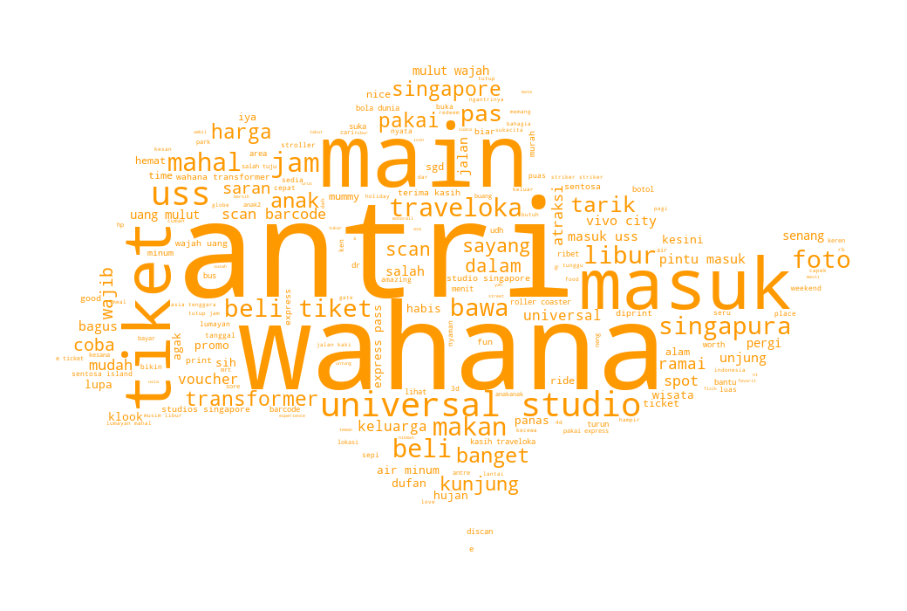

In [32]:
mask = (df['sentiment'] == 'neutral')
neu_df = df[mask]
neu_text = " ".join(i for i in neu_df.new_reviews)
show_wordcloud(neu_text, "neutral")

In [33]:
neu_wordcount = WordCloud().process_text(neu_text)
neu_wordcount = pd.DataFrame(neu_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
save_excel_sheet(neu_wordcount, f"{attraction}_topwords.xlsx", 'neutral')
neu_wordcount.head(15)

,word,frequency
63,antri,122
5,wahana,112
6,main,90
86,masuk,86
144,tiket,71
1196,universal studio,67
116,uss,64
69,jam,42
46,makan,37
349,traveloka,36


### Top Words in Negative Sentiment

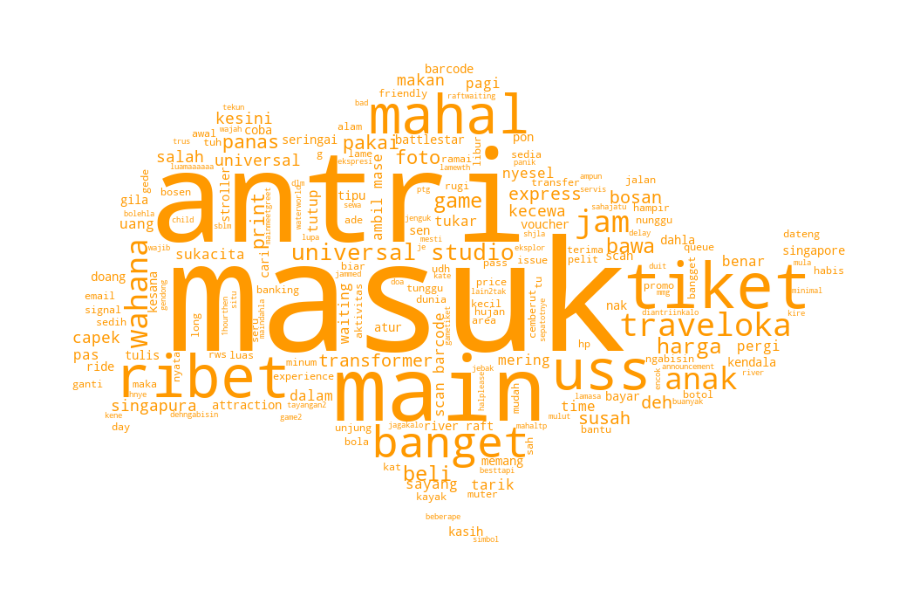

In [34]:
mask = (df['sentiment'] == 'negative')
neg_df = df[mask]
neg_text = " ".join(i for i in neg_df.new_reviews)
show_wordcloud(neg_text, "negative")

In [35]:
neg_wordcount = WordCloud().process_text(neg_text)
neg_wordcount = pd.DataFrame(neg_wordcount.items(), columns=['word', 'frequency']).sort_values(by=['frequency'], ascending=False)
save_excel_sheet(neu_wordcount, f"{attraction}_topwords.xlsx", 'negative')
neg_wordcount.head(15)

,word,frequency
6,masuk,29
12,antri,23
82,main,21
14,tiket,17
132,ribet,15
123,mahal,13
86,uss,13
175,traveloka,11
171,banget,11
0,anak,10
